
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./mcWhorter_interactive.ipynb" download="mcWhorter_interactive.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=mcWhorter_interactive.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/TH2M/H2/mcWhorter_interactive/mcWhorter_interactive.py"><img src="https://img.shields.io/static/v1?label=Source:&message=mcWhorter_interactive.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/master?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/TH2M/H2/mcWhorter_interactive/mcWhorter_interactive.py%26branch=master%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

# McWhorter Problem
<cite>[McWhorter and Sunada][1]</cite> propose an analytical solution to the two-phase flow equation. A one-dimensional problem was considered which describes the flow of two incompressible, immiscible fluids through a porous medium, where the wetting phase (water) displaces the non-wetting fluid (air or oil) in the horizontal direction (without the influence of gravity).

![mcWhorter_concept.png](figures/mcWhorter_concept.png)

[1]: https://doi.org/10.1029/WR026i003p00399

### Material and Problem parameter

The parameter for this problem are stored in a CSV file. Let's look at the table below. The column "Key" shows the parameter name in the PRJ file. The column "Value" shows current parameter value. The columns "Range min", "Range max" and "Scale" are used in the next section to define sliders to interact with the analytic solution.

In [1]:
import json
import os
import threading

import ipywidgets as widgets
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ogstools as ogs
import pandas as pd
import pyvista as pv
from helper import (
    create_1d_mesh,
    create_boundary_line_meshes,
    plot_with_error,
    render_latex_table,
)
from IPython.display import display
from mcwhorter import BrooksCorey, McWhorter
from template import file_from_template

parameter_table = pd.read_csv("parameter.csv", quotechar="'")

# We look at this column later
df_OGSTools = parameter_table[["Key", "OGSTools"]]
parameter_table = parameter_table.drop("OGSTools", axis=1)

render_latex_table(parameter_table, latex_column="Symbol")

<IPython.core.display.Javascript object>

## Analytical solution
The analytical solution is calculated according to <cite>[McWhorter and Sunada][1]</cite>. The initial saturation is Si in the domain. At $t=0$ the saturation at $x=0$ becomes S0. The analytical solution is calculated for $t=1000$ s.

[1]: https://doi.org/10.1029/WR026i003p00399

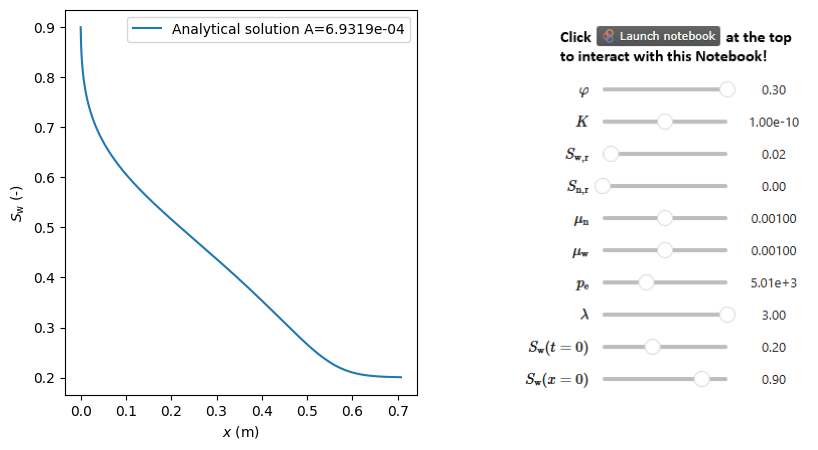

In [2]:
def plot_f(mun, muw, K, phi, lambda_, Pe, S0, Si, Snr, Swr, **kwargs):
    model = BrooksCorey(Pe, lambda_, Snr, Swr)
    problem = McWhorter(model, phi, K, muw, mun, S0, Si)
    problem.plot_solution()


# Creating sliders for interactive plots based on the DataFrame
sliders = {}
lock = threading.RLock()  # Prevent update loops


# Residual Saturations Snr, Swr limit values for Initial and boundary saturation Si, S0
def update_constraints(_change):
    with lock:
        try:
            # Calculate new bounds from current constraint values with small buffer
            buffer = 0.001
            min_bound = sliders["Swr"].value + buffer
            max_bound = 1 - sliders["Snr"].value - buffer

            # Update constraints, Values are automatically set according to range
            with sliders["Si"].hold_trait_notifications():
                sliders["Si"].min = min_bound
                sliders["Si"].max = min(max_bound, sliders["S0"].value)  # S0 > Si!

            with sliders["S0"].hold_trait_notifications():
                sliders["S0"].min = max(min_bound, sliders["Si"].value)  # S0 > Si!
                sliders["S0"].max = max_bound

        except Exception as e:
            print(f"Constraint update failed: {e}")


# Initialize sliders
for _idx, row in parameter_table.iterrows():
    key = row["Key"]
    sym = row["Symbol"]
    label = rf"\({sym}\)"

    if row["Scale"] == "log":
        slider = widgets.FloatLogSlider(
            value=row["Value"],
            base=10,
            min=np.log10(row["Range min"]),
            max=np.log10(row["Range max"]),
            step=0.01,
            description=label,
        )
    else:
        slider = widgets.FloatSlider(
            value=row["Value"],
            min=row["Range min"],
            max=row["Range max"],
            step=0.01,
            description=label,
        )

    # Add observers for constraint sliders
    if key in ["Swr", "Snr", "Si", "S0"]:
        slider.observe(update_constraints, names="value")

    sliders[key] = slider

update_constraints(None)

if "CI" in os.environ:  # static plot
    params = {k: v.value for k, v in sliders.items()}
    model = BrooksCorey(
        params["Pe"],
        params["lambda_"],
        params["Snr"],
        params["Swr"],
    )
    problem = McWhorter(
        model,
        params["phi"],
        params["K"],
        params["muw"],
        params["mun"],
        params["S0"],
        params["Si"],
    )
    img = mpimg.imread("figures/slider.png")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[1].imshow(img)
    axes[1].axis("off")  # Achsen ausblenden
    plt.sca(axes[0])
    problem.plot_solution()
    plt.show()

else:  # interactive plot
    # Display sliders and plot
    ui = widgets.VBox(list(sliders.values()))
    out = widgets.interactive_output(plot_f, sliders)
    display(widgets.HBox([out, ui]))

## Numerical solutions

For the numerical solution, we compare the Thermal-2-Phase-Hydro-Mechanical (TH2M) and the Two-phase Flow formulation.

1. The first step is to create a matching mesh that capture the penetration depth of the wetting fluid.
2. Because the OGS models use the capillary pressure as a primary variable, the boundary and initial conditions need to be converted from saturations to pressures.

Tip: Pick the parameters you would like to study with the sliders above and run the code blocks below to compare the results of the analytical and numerical model.

In [3]:
# parameters defined by the current slider settings
params = {k: v.value for k, v in sliders.items()}

# calculate analytical solution with the
model = BrooksCorey(
    params["Pe"],
    params["lambda_"],
    params["Snr"],
    params["Swr"],
)
problem = McWhorter(
    model,
    params["phi"],
    params["K"],
    params["muw"],
    params["mun"],
    params["S0"],
    params["Si"],
)
x_ref, Sw_ref = problem.get_solution()

# 1. Create meshes according to the penetration depth of the wetting fluid

depth = max(x_ref)  # penetration depth of the wetting fluid
factor = 5.0  # mesh should be factor times larger than the depth
Nel = 100  # number of mesh elements

print(f"penetration depth of the wetting fluid: {depth}")

# 1.1 Mesh for TwoPhaseFlowPP
mesh = create_1d_mesh(
    point_a=(0.0, 0.0, 0.0),
    point_b=(depth * factor, 0.0, 0.0),
    num_points=Nel + 1,
    mesh_type="line",
)
mesh.save(r"mesh_line.vtu")

coords = {"x1": mesh.GetBounds()[1], "x2": 0.5 * mesh.GetBounds()[1]}
file_from_template(coords, "mcwt.template", "mcwt.gml")

# 1.2 Mesh for TH2M
mesh = create_1d_mesh(
    point_a=(0.0, 0.0, 0.0),
    point_b=(depth * factor, 0.0, 0.0),
    num_points=Nel + 1,
    mesh_type="quad",
)
mesh.save(r"mesh_quad.vtu")

boundary_left, boundary_right = create_boundary_line_meshes(
    point_a=(0.0, 0.0, 0.0), point_b=(depth * factor, 0.0, 0.0), num_points=Nel + 1
)
boundary_left.save("boundary_left_test.vtu")

#!checkMesh -v mesh_quad.vtu
!identifySubdomains -m mesh_quad.vtu -- boundary_left_test.vtu
#!checkMesh -v boundary_left_test.vtu

# 2. Calculate capillary pressures
params["pci"] = model.pc(params["Si"])
params["pc0"] = model.pc(params["S0"])

print(f"Si = {params['Si']} -> pci = {params['pci']}")
print(f"S0 = {params['S0']} -> pc0 = {params['pc0']}")

penetration depth of the wetting fluid: 0.7072512405219576
2 replacements made.


[2025-08-04 13:54:40.305] [ogs] [info] Mesh reading time: 0.000721964 s
[2025-08-04 13:54:40.305] [ogs] [info] MeshNodeSearcher construction time: 1.9046e-05 s
[2025-08-04 13:54:40.305] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 5.3e-06 s
[2025-08-04 13:54:40.305] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 3.195e-05 s
[2025-08-04 13:54:40.305] [ogs] [info] identifySubdomains time: 5.3781e-05 s
[2025-08-04 13:54:40.305] [ogs] [info] writing time: 0.000451157 s
[2025-08-04 13:54:40.305] [ogs] [info] Entire run time: 0.00134541 s


Si = 0.2 -> pci = 8793.060606699997
S0 = 0.9 -> pc0 = 5180.877745148153


### Updating the PRJ file

Now we can update the PRJ files and run the simulations. We use the methods `replace_parameter_value()` and `replace_phase_property_value()` from ogstools for this task.

Parameters in the `<parameters>`-block can be set using the `replace_parameter_value()` method.

In the PRJ file, we need to add `<parameter>` in the `<parameters>` block, for each property, that can be defined by parameters:

```xml
<parameter>
    <name>k0</name>
    <type>Constant</type>
    <value>1e-10</value>
</parameter>
```

To use this parameter, we need to adjust the relevant `<property>` block. In the subsequent block, the permeability is defined by `<value>`.

```xml
<property>
    <name>permeability</name>
    <type>Constant</type>
    <value>1e-10</value>
</property>
```

To use the value defined in the parameter k0, we need to alter the `<property>` block. The `<type>` needs to be "Parameter". Instead of `<value>` the `<parameter_name>` is required.

```xml
<property>
    <name>permeability</name>
    <type>Parameter</type>
    <parameter_name>k0</parameter_name>
</property>
```

The two phase flow properties in the `<properties>`-block can be replaced by the `replace_phase_property_value()` method. This methods requires some parameters to find all occurrences of the property. To handle this, we provided the information in the CSV file as a JSON list of dictionaries. Here we want to set the residual liquid saturation in the $p_c(S_w)$-Curve, for $k_{rw}(S_w)$ and for $k_{rn}(S_w)$.

```json
[{"medium id": 0,
  "name": "saturation",
  "valuetag": "residual_liquid_saturation",
  "propertytype":"SaturationBrooksCorey"},
 {"medium id": 0,
  "name": "relative_permeability_nonwetting_phase",
  "valuetag": "residual_liquid_saturation",
  "propertytype":"RelPermBrooksCoreyNonwettingPhase"},
 {"medium id": 0,
  "name": "relative_permeability",
  "valuetag": "residual_liquid_saturation",
  "propertytype":"RelPermBrooksCorey"}]
```

Now we can parse the information in the "OGSTools" column of our CSV file, that we need for these `replace-...` methods.

In [4]:
replace_info = {}

for _index, row in df_OGSTools.iterrows():
    if row["OGSTools"] == "Parameter":
        replace_info[row["Key"]] = row["OGSTools"]
    else:
        replace_info[row["Key"]] = json.loads(row["OGSTools"])

# Add infos for calculated parameter
replace_info["pci"] = "Parameter"
replace_info["pc0"] = "Parameter"

Finally, we can update the PRJ file and run the simulations.

In [5]:
# Simulate problem with TwoPhaseFlowPP and TH2M
prj_files = [r"mcWhorter_TwoPhasePP.prj", r"mcWhorter_TH2M.prj"]

for prj_file in prj_files:
    prj = ogs.Project(input_file=prj_file, output_file=prj_file)
    for key, paramvalue in params.items():
        try:
            if replace_info[key] == "Parameter":
                prj.replace_parameter_value(name=key, value=paramvalue)
            else:
                for r in replace_info[key]:
                    prj.replace_medium_property_value(
                        mediumid=r["medium id"],
                        name=r["name"],
                        value=paramvalue,
                        propertytype=r["propertytype"],
                        valuetag=r["valuetag"],
                    )
        except RuntimeError:
            print(f"Parameter {key} not found...")
    prj.write_input()
    prj.run_model()

Parameter Si not found...
Parameter S0 not found...


Project file written to output.
Simulation: mcWhorter_TwoPhasePP.prj
Status: finished successfully.
Execution took 2.5728087425231934 s
Parameter Si not found...
Parameter S0 not found...


Project file written to output.
Simulation: mcWhorter_TH2M.prj
Status: finished successfully.
Execution took 22.1356303691864 s


## Evaluation and Results

['capillary_pressure', 'gas_pressure', 'saturation']
['capillary_pressure', 'capillary_pressure_interpolated', 'displacement', 'epsilon', 'gas_density', 'gas_pressure', 'gas_pressure_interpolated', 'k_rel_G', 'k_rel_L', 'liquid_density', 'liquid_pressure_interpolated', 'porosity', 'saturation', 'sigma', 'temperature', 'temperature_interpolated', 'velocity_gas', 'velocity_liquid', 'xmCG', 'xmWL', 'xnCG']


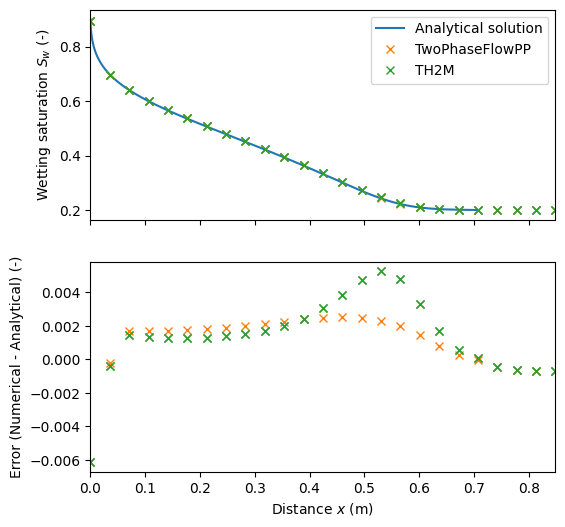

In [6]:
# 1. Plot analytical solution
plotter = plot_with_error(
    x_ref,
    Sw_ref,
    "C0-",
    "Analytical solution",
    "Distance $x$ (m)",
    "Wetting saturation $S_w$ (-)",
    "Error (Numerical - Analytical) (-)",
)

# 2. Read results from TwoPhaseFlowPP
labels = ["TwoPhaseFlowPP", "TH2M"]
results = [
    "twophaseflow_test_t_1000.000000.vtu",
    "result_McWhorter_H2_ts_110_t_1000.000000.vtu",
]

i = 1
for label, result in zip(labels, results):
    mesh = pv.read(result)
    print(mesh.point_data.keys())

    Sw = mesh["saturation"]
    x = mesh.points[:, 0]

    ind = np.argsort(x)
    x = x[ind]
    Sw = Sw[ind]

    plotter.append(x, Sw, f"C{i}x", label)
    i = i + 1

# show plot

plotter.plot([0, depth * 1.2])

## Literature

- McWhorter, D. B., and D. K. Sunada (1990), Exact integral solutions for two-phase flow, Water Resour. Res., 26(3), 399–413, <cite>[doi:10.1029/WR026i003p00399][1]</cite>.
- Radek Fučík, https://mmg.fjfi.cvut.cz/~fucik/index.php?page=exact

[1]: https://doi.org/10.1029/WR026i003p00399
